In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression, SGDRegressor, PassiveAggressiveRegressor
import sklearn
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression, mutual_info_regression, SelectFpr, SelectFdr, SelectFwe, RFE
from sklearn.decomposition import PCA
from sklearn import neighbors
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import time
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn import preprocessing
from sklearn.utils import shuffle
import csv

In [42]:
corona_economy = pd.read_csv('corona_economy_employment.csv')
print(corona_economy.head(2))

   employment  year  month  day  days from begin  spltov  new_case_count  \
0     0.00387  2020      2   24                1       1         -0.0246   
1     0.00386  2020      2   25                2       1         -0.0336   

   case_count  new_death_count  death_count  ...  Construction Permits  \
0     -0.0234          -0.0647      -0.0125  ...             -0.368118   
1     -0.0346          -0.0593      -0.0174  ...             -0.368118   

   Construction Spending Residential       CPI  Inflation    NASDAQ       DJI  \
0                          -0.913779 -0.806266  -0.524099 -1.367142 -0.385849   
1                          -0.913779 -0.806266  -0.663153 -1.498528 -0.617692   

      SP500   Bitcoin  spend_all  revenue_all  
0 -0.713863 -0.689885    -0.0453      -0.0418  
1 -0.949144 -0.710342    -0.0461      -0.0444  

[2 rows x 32 columns]


In [43]:
corona_economy.columns

Index(['employment', 'year', 'month', 'day', 'days from begin', 'spltov',
       'new_case_count', 'case_count', 'new_death_count', 'death_count',
       'new_test_count', 'test_count', 'gps_retail_and_recreation',
       'gps_grocery_and_pharmacy', 'gps_parks', 'gps_transit_stations',
       'gps_workplaces', 'gps_residential', 'gps_away_from_home', 'loc_FL',
       'loc_CA', 'loc_TX', 'Construction Permits',
       'Construction Spending Residential', 'CPI', 'Inflation', 'NASDAQ',
       'DJI', 'SP500', 'Bitcoin', 'spend_all', 'revenue_all'],
      dtype='object')

In [44]:
corona_economy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1308 entries, 0 to 1307
Data columns (total 32 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   employment                         1308 non-null   float64
 1   year                               1308 non-null   int64  
 2   month                              1308 non-null   int64  
 3   day                                1308 non-null   int64  
 4   days from begin                    1308 non-null   int64  
 5   spltov                             1308 non-null   int64  
 6   new_case_count                     1308 non-null   float64
 7   case_count                         1308 non-null   float64
 8   new_death_count                    1308 non-null   float64
 9   death_count                        1308 non-null   float64
 10  new_test_count                     1308 non-null   float64
 11  test_count                         1308 non-null   float

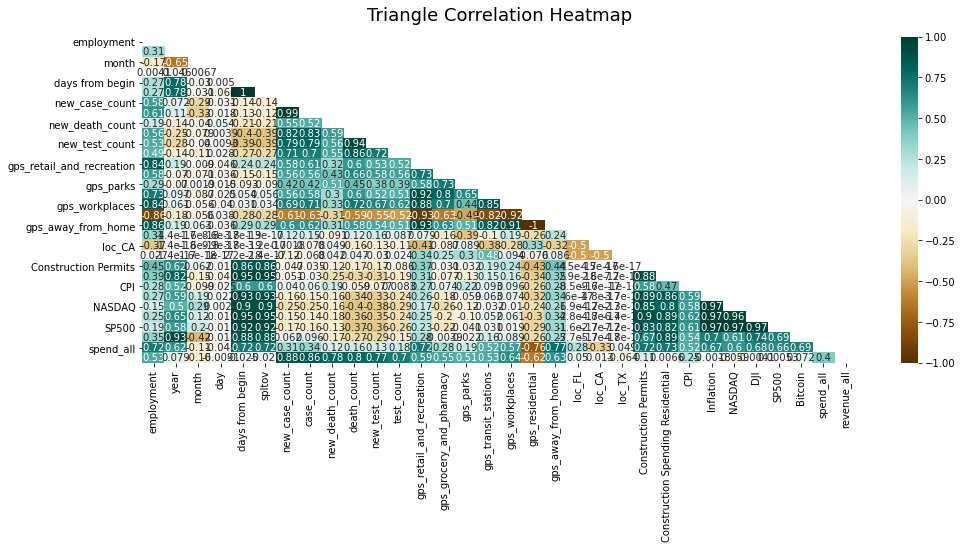

In [47]:
corona_economy.corr()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(corona_economy.corr(), dtype=np.bool))
heatmap = sns.heatmap(corona_economy.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Triangle Correlation Heatmap', fontdict={'fontsize':18}, pad=16);

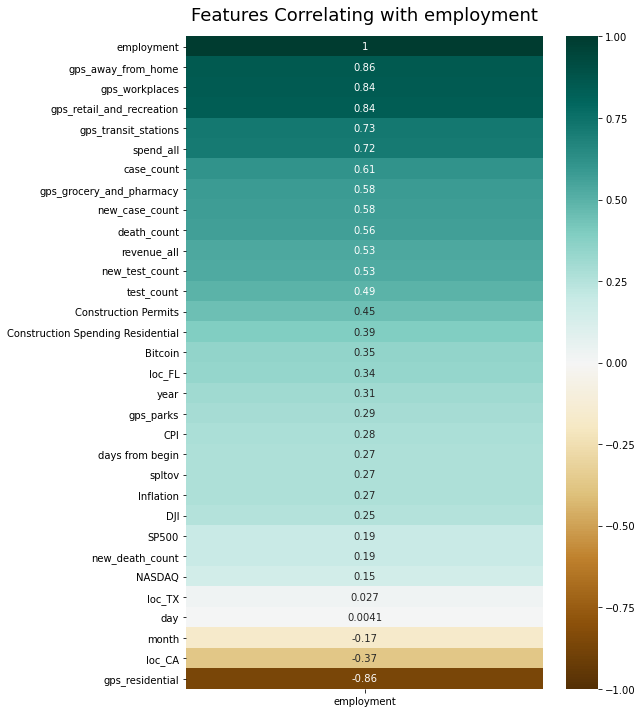

In [48]:
corona_economy.corr()[['employment']].sort_values(by='employment', ascending=False)

plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(corona_economy.corr()[['employment']].sort_values(by='employment', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with employment', fontdict={'fontsize':18}, pad=16);

In [45]:
def standardize_data(subject_='corona_economy_employment'):
    df = pd.read_csv(subject_ + '.csv')
    print("Column headings:")
    print(df.columns)
    columns = df.columns
    print(len(columns))

    uniques = []
    for i in columns:
        uniques.append(df[i].unique())
        if len(uniques[-1]) < 50:
            print(i, uniques[-1])
    for i in columns:
        d_type = df[i].dtype
        if d_type != 'float64' and d_type != 'int64':
            print(i)

    if subject_ == 'corona_economy_employment':
        labels = np.zeros((3, len(df['year'])))

        counter = 0
        for column in columns:
            if column == 'year':
                break
            labels[counter] = df[column]
            counter += 1

        m = np.mean(labels, axis=1)
        s = np.std(labels, axis=1)
        np.savetxt('train_mean_'+subject_+'_all.txt', m, delimiter=',')
        np.savetxt('train_std_'+subject_+'_all.txt', s, delimiter=',')
        data = np.array(df)
        scaler = None
        scaler = preprocessing.StandardScaler()
        scaler.fit(data)
        data_trans = scaler.transform(data)
        np.savetxt('data/transformed_' + subject_ + '.txt', data_trans, delimiter=',')

In [46]:
def split_index(subject_='corona_economy_employment', split_type_='5fold', fold_total_=5):
    if split_type_ == '5fold':
        df = pd.read_csv(subject_ +'.csv')

        for k in range(5):
            eval_index = []
            nums = df['spltov']
            for i in range(len(nums)):
                if 1 + k * 3 <= nums[i] < 1 + k * 3 + 3:
                    eval_index.append(i)
            test_index = []
            nums = df['spltov']
            for i in range(len(nums)):
                if nums[i] >= 16:
                    test_index.append(i)
            train_index = []
            for i in range(len(nums)):
                if i not in test_index:
                    if i not in eval_index:
                        train_index.append(i)
            np.savetxt('data/train_index_' + subject_ + '_' + split_type_ + '_' + str(k) + '.txt', np.array(train_index, dtype='int'), fmt='%d', delimiter=',')
            np.savetxt('data/test_index_' + subject_ + '_' + split_type_ + '_' + str(k) + '.txt', np.array(test_index, dtype='int'), fmt='%d',delimiter=',')
            np.savetxt('data/valid_index_' + subject_ + '_' + split_type_ + '_' + str(k) + '.txt', np.array(eval_index, dtype='int'), fmt='%d', delimiter=',')

    if split_type_ == 'time':
        df = pd.read_csv(subject_ +'.csv')

        for k in range(1,fold_total_):
            gap = 16 // fold_total_
            eval_index = []
            nums = df['spltov']
            months = range(1,17)
            months_train = []
            months_test = []
            months_eval = []
            for month in months:
                if 1 + k * gap <= month < 1 + k * gap + gap:
                    months_eval.append(month)
                if 1 + k * gap + gap <= month < 1 + k * gap + 2 * gap:
                    months_test.append(month)
                if 1 + k * gap > month:
                    months_train.append(month)

            for i in range(len(nums)):
                if 1 + k * gap <= nums[i] < 1 + k * gap + gap:
                    eval_index.append(i)
            test_index = []
            nums = df['spltov']
            for i in range(len(nums)):
                if 1 + k * gap + gap <= nums[i] < 1 + k * gap + 2 * gap:
                    test_index.append(i)
            train_index = []
            for i in range(len(nums)):
                if 1 + k * gap > nums[i]:
                        train_index.append(i)
            np.savetxt('data/train_index_' + subject_ + '_' + split_type_ + '_' + str(k) + '.txt', np.array(train_index, dtype='int'), fmt='%d', delimiter=',')
            np.savetxt('data/test_index_' + subject_ + '_' + split_type_ + '_' + str(k) + '.txt', np.array(test_index, dtype='int'), fmt='%d',delimiter=',')
            np.savetxt('data/valid_index_' + subject_ + '_' + split_type_ + '_' + str(k) + '.txt', np.array(eval_index, dtype='int'), fmt='%d', delimiter=',')
            print(k, months_train, months_eval, months_test)

In [33]:
def load_split(subject_, data_, split_type_, k):
    train_index = np.loadtxt('data/train_index_' + subject_ + '_' + split_type_ + '_' + str(k) + '.txt', delimiter=',', dtype='int')
    test_index = np.loadtxt('data/test_index_' + subject_ + '_' + split_type_ + '_' + str(k) + '.txt', delimiter=',', dtype='int')
    eval_index = np.loadtxt('data/valid_index_' + subject_ + '_' + split_type_ + '_' + str(k) + '.txt', delimiter=',', dtype='int')
    # test_index = np.loadtxt('data/test_index_cost_5fold_4.txt', delimiter=',')

    test = data_[test_index]
    valid = data_[eval_index]
    train = data_[train_index]
    # print(valid.shape, test.shape, train.shape)

    train_x = train[:, 1:]
    train_y = train[:, 0:1]
    test_x = test[:, 1:]
    test_y = test[:, 0:1]
    valid_x = valid[:, 1:]
    valid_y = valid[:, 0:1]

    train_x_shuffled, train_y_shuffled = shuffle(train_x, train_y, random_state=0)
    return train_x_shuffled, train_y_shuffled, test_x, test_y, valid_x, valid_y

In [34]:
def mape(y_t, y_p):
    return np.mean(np.abs((y_t - y_p) / y_t)) * 100

In [35]:
def convert(y_, subject_, label_counter_):

    m = float(np.loadtxt('train_mean_' + subject_ + '_all.txt', delimiter=',')[label_counter_])
    s = float(np.loadtxt('train_std_' + subject_ + '_all.txt', delimiter=',')[label_counter_])
    return np.array(y_) * s + m

In [36]:
def feature_selection(type_fs, feature_, label_, feature_test_, k_=100, subject='corona_economy_employment', label_counter_=0, fold_=4, split_method_='5fold', fold_total_=5):
    if type_fs != 'PCA':
        support_ = np.loadtxt('support/' + subject + '/' + type_fs + '_' + str(label_counter_) + '_' + split_method_ + '_' + str(fold_total_) + '_' + str(k_) + '_' + str(fold_) + '.txt')
        support_ = np.array(support_, dtype=bool)
        feature_ = feature_[:, support_]
        feature_test_ = feature_test_[:, support_]
    else:
        feature_ = np.loadtxt('support/' + subject + '/' + type_fs + '_' + str(label_counter_) + '_' + split_method_ + '_' + str(fold_total_) + '_' + str(k_) + '_' + str(fold_) + '.txt')
        feature_test_ = np.loadtxt('support/' + subject + '/' + type_fs + '_' + str(label_counter_) + '_' + split_method_ + '_' + str(fold_total_) + '_' + str(k_) + '_' + str(fold_) + '_test.txt')
        if k_ == 1:
            feature_ = np.reshape(feature_, (len(feature_), 1))
            feature_test_ = np.reshape(feature_test_, (len(feature_test_), 1))
    return feature_, feature_test_

In [37]:
def save_feature_selection(type_fs, feature_, label_, feature_test_, k_=100, subject='corona_economy_employment', label_counter_=0, fold_=4, split_method_='5fold', fold_total_=5):
    if type_fs == 'Linear':
        lsvc_ = LinearRegression().fit(feature_, label_)
        model_ = SelectFromModel(lsvc_, threshold=str(k_) + '*mean', prefit=True)

    if type_fs == 'RF':
        lsvc_ = RandomForestRegressor(n_estimators=10).fit(feature_, label_)
        model_ = SelectFromModel(lsvc_, threshold=str(k_) + '*mean', prefit=True)

    if type_fs == 'SVR':
        lsvc_ = SVR(cache_size=5000).fit(feature_, label_)
        model_ = SelectFromModel(lsvc_, threshold=str(k_) + '*mean', prefit=True)

    if type_fs == 'Ridge':
        lsvc_ = linear_model.Ridge().fit(feature_, label_)
        model_ = SelectFromModel(lsvc_, threshold=str(k_) + '*mean', prefit=True)

    if type_fs == 'KNN':
        lsvc_ = neighbors.KNeighborsRegressor().fit(feature_, label_)
        model_ = SelectFromModel(lsvc_, threshold=str(k_) + '*mean', prefit=True)

    if type_fs == 'BaysianRidge':
        lsvc_ = linear_model.BayesianRidge().fit(feature_, label_)
        model_ = SelectFromModel(lsvc_, threshold=str(k_) + '*mean', prefit=True)

    if type_fs == 'DT':
        lsvc_ = tree.DecisionTreeRegressor().fit(feature_, label_)
        model_ = SelectFromModel(lsvc_, threshold=str(k_) + '*mean', prefit=True)

    if type_fs == 'FCLASSIF':
        model_ = SelectKBest(f_regression, k=k_).fit(feature_, label_)
        support_ = model_.get_support()

    if type_fs == 'MFCLASSIF':
        model_ = SelectKBest(mutual_info_regression, k=k_).fit(feature_, label_)
        support_ = model_.get_support()

    if type_fs == 'SELECTFPR':
        model_ = SelectFpr(alpha=k_).fit(feature_, label_)
        support_ = model_.get_support()

    if type_fs == 'SELECTFDR':
        model_ = SelectFdr(alpha=k_).fit(feature_, label_)
        support_ = model_.get_support()

    if type_fs == 'SELECTFWE':
        model_ = SelectFwe(alpha=k_).fit(feature_, label_)

    if type_fs == 'RFELinear':
        lsvc_ = LinearRegression().fit(feature_, label_)
        model_ = RFE(lsvc_, k_, step=10).fit(feature_, label_)

    if type_fs == 'RFERF':
        lsvc_ = RandomForestRegressor(n_estimators=10).fit(feature_, label_)
        model_ = RFE(lsvc_, k_, step=10).fit(feature_, label_)

    if type_fs == 'RFESVR':
        lsvc_ = SVR().fit(feature_, label_)
        model_ = RFE(lsvc_, k_, step=10).fit(feature_, label_)

    if type_fs == 'RFERidge':
        lsvc_ = linear_model.Ridge().fit(feature_, label_)
        model_ = RFE(lsvc_, k_, step=10).fit(feature_, label_)

    if type_fs == 'RFEKNN':
        lsvc_ = neighbors.KNeighborsRegressor().fit(feature_, label_)
        model_ = RFE(lsvc_, k_, step=10).fit(feature_, label_)

    if type_fs == 'RFEBaysianRidge':
        lsvc_ = linear_model.BayesianRidge().fit(feature_, label_)
        model_ = RFE(lsvc_, k_, step=10).fit(feature_, label_)

    if type_fs == 'RFEDT':
        lsvc_ = tree.DecisionTreeRegressor().fit(feature_, label_)
        model_ = RFE(lsvc_, k_, step=10).fit(feature_, label_)

    if type_fs != 'PCA':
        support_ = model_.get_support()
        np.savetxt('support/'+ subject + '/' + type_fs + '_' + str(label_counter_) + '_' + split_method_ + '_' + str(fold_total_) + '_' + str(k_) + '_' + str(fold_) + '.txt', support_)
    else:
        pca = PCA(n_components=k_)
        pca.fit(feature_)
        feature_transformed = pca.transform(feature_)
        np.savetxt('support/'+ subject + '/' + type_fs + '_' + str(label_counter_) + '_' + split_method_ + '_' + str(fold_total_) + '_' + str(k_) + '_' + str(fold_) + '.txt', feature_transformed)
        feature_test_transformed = pca.transform(feature_test_)
        np.savetxt('support/'+ subject + '/' + type_fs + '_' + str(label_counter_) + '_' + split_method_ + '_' + str(fold_total_) + '_' + str(k_) + '_' + str(fold_) + '_test.txt', feature_test_transformed)

In [38]:
def classifier(type_clf, clf_k_=1):
    if type_clf == 'Linear':
        clf_ = LinearRegression()

    if type_clf == 'RF':
        clf_ = RandomForestRegressor(max_depth=clf_k_, n_estimators=10)

    if type_clf == 'SVR':
        clf_ = SVR(C=clf_k_)

    if type_clf == 'Ridge':
        clf_ = linear_model.Ridge(alpha=clf_k_)

    if type_clf == 'KNN':
        clf_ = neighbors.KNeighborsRegressor(n_neighbors=clf_k_)
    if type_clf == 'BaysianRidge':
        clf_ = linear_model.BayesianRidge( alpha_1=clf_k_, alpha_2=clf_k_,
                 lambda_1=clf_k_, lambda_2=clf_k_)
    if type_clf == 'DT':
        clf_ = tree.DecisionTreeRegressor(max_depth=clf_k_)
    if type_clf == 'NN':
        clf_ = MLPRegressor(hidden_layer_sizes=[clf_k_], max_iter=1000, verbose=False)
    if type_clf == 'SGD':
        clf_ = SGDRegressor(l1_ratio=clf_k_)
    if type_clf == 'PA':
        clf_ = PassiveAggressiveRegressor(C=clf_k_)

    return clf_


In [39]:
def float_maker(x_):
    x_ = float("{0:.4f}".format(x_))
    return x_

In [40]:
for subject in ['corona_economy_employment']:
    standardize_data(subject)
    # for split_method in ['5fold', 'time]:
    for split_method in ['time']:
        do_feature_selection = 1
        do_feature_selection_test = 0
        fold_total = 5
        each_run = 1
        dis_ind = []
        dis_ind_f = []
        # split_method = '5fold'
        split_index(subject, split_method, fold_total)
        data = np.loadtxt('data/transformed_' + subject + '.txt', delimiter=',')
        _, train_y_all, _, _, _, _ = load_split(subject, data, split_method, 4)

        if split_method == '5fold   ':
            fold_range = range(5)
        if split_method == 'time':
            fold_range = range(1,5)
        if do_feature_selection:
            for fold in fold_range:
                train_x, train_y_all, test_x, test_y_all, valid_x, valid_y_all = load_split(subject, data,
                                                                                            split_method, fold)
                for label_counter in range(len(train_y_all[0])):
                    train_y = train_y_all[:, label_counter]
                    test_y = test_y_all[:, label_counter]
                    valid_y = valid_y_all[:, label_counter]

                    for selection in ['RF', 'Ridge', 'BaysianRidge', 'DT', 'FCLASSIF', 'MFCLASSIF', 'RFERF',
                                      'RFERidge',
                                      'RFEBaysianRidge',
                                      'RFEDT']:
                        print(fold, label_counter, selection)
                        if selection in ['Linear', 'RF', 'SVR', 'Ridge', 'KNN', 'BaysianRidge', 'DT']:
                            selection_flag = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75]
                        if selection in ['FCLASSIF', 'MFCLASSIF']:
                            selection_flag = [10, 15, 20, 25]
                        if selection in ['RFERF', 'RFERidge', 'RFEBaysianRidge', 'RFEDT']:
                            selection_flag = [10, 15, 20, 25]

                        for selection_k in selection_flag:
                            # time_1 = time.time()
                            # print(selection_k)
                            if selection != 'NONE':
                                save_feature_selection(selection, train_x, train_y, valid_x, selection_k,
                                                       subject, label_counter, fold, split_method, fold_total)
                            # print(time.time()-time_1)
        print(len(train_y_all[0]))
        for label_counter in range(len(train_y_all[0])):
            results_e = np.empty((10 * 13 * 5, 9), dtype=object)

            results_detailed = np.empty((10 * 13 * 48 * 2, 9), dtype=object)

            counter = 0
            counter_detailed = 0
            # for classifier_type in ['Linear', 'RF', 'Ridge', 'KNN', 'DT', 'NN']:
            # for classifier_type in ['Linear', 'RF', 'Ridge', 'KNN', 'BaysianRidge', 'DT', 'NN', 'SGD', 'PA']:
            # for classifier_type in ['Linear', 'RF', 'Ridge', 'KNN', 'BaysianRidge', 'DT', 'SGD', 'PA']:
            for fold in fold_range:
                for classifier_type in ['Linear', 'Ridge', 'BaysianRidge', 'SGD', 'PA', 'RF', 'KNN', 'DT', 'NN']:
                    # for selection in ['NONE', 'RF', 'Ridge', 'DT']:
                    for selection in ['NONE', 'RF', 'Ridge', 'BaysianRidge', 'DT', 'FCLASSIF', 'MFCLASSIF', 'RFERF',
                                      'RFERidge',
                                      'RFEBaysianRidge',
                                      'RFEDT']:
                        if selection in ['NONE']:
                            selection_flag = [999]
                        if selection in ['Linear', 'RF', 'SVR', 'Ridge', 'KNN', 'BaysianRidge', 'DT']:
                            selection_flag = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75]
                        if selection in ['FCLASSIF', 'MFCLASSIF']:
                            selection_flag = [10, 15, 20, 25]
                        if selection in ['RFERF', 'RFERidge', 'RFEBaysianRidge', 'RFEDT']:
                            selection_flag = [10, 15, 20, 25]

                        if classifier_type == 'Linear':
                            k_flag = [999]
                        if classifier_type == 'RF':
                            k_flag = [5, 20, 50, 75, 100, 200]

                        if classifier_type == 'SVR':
                            k_flag = [1, 100]

                        if classifier_type == 'Ridge':
                            k_flag = [0.1, 1, 10, 100, 10000, 1e6]

                        if classifier_type == 'KNN':
                            k_flag = [1, 3, 5, 7, 10, 16]

                        if classifier_type == 'BaysianRidge':
                            k_flag = [0.1, 1, 10, 100, 10000, 1e6]

                        if classifier_type == 'DT':
                            k_flag = [5, 20, 50, 75, 100, 200]

                        if classifier_type == 'NN':
                            k_flag = [16, 64, 256]

                        if classifier_type == 'SGD':
                            k_flag = [0, 0.15, 0.3, 0.5, 0.75, 1]

                        if classifier_type == 'PA':
                            k_flag = [0.1, 1, 10, 100, 10000, 1e6]

                        best_r = -1e300
                        best_e = 1e300
                        best_truths = []
                        best_preds = []
                        best_truths_c = []
                        best_preds_c = []
                        for k_neigh in k_flag:
                            for selection_k in selection_flag:
                                dummy_mae = []
                                dummy_r = []
                                dummy_mse = []
                                preds = []
                                truths = []
                                preds_c = []
                                truths_c = []
                                train_x, train_y_all, test_x, test_y_all, valid_x, valid_y_all = load_split(subject, data, split_method, fold)
                                train_y = train_y_all[:, label_counter]
                                # test_y = test_y_all[:, label_counter]
                                valid_y = valid_y_all[:, label_counter]
                                valid_y_c = convert(valid_y, subject, label_counter)
                                # test_y_c = convert(test_y, subject, label_counter)


                                if selection != 'NONE':
                                    train_x, valid_x = feature_selection(selection, train_x, train_y, valid_x, selection_k, subject, label_counter, fold, split_method, fold_total)
                                    if selection != 'PCA':
                                        if train_x.shape[1] == 0:
                                            continue
                                else:
                                    train_x, valid_x = train_x, valid_x

                                clf = classifier(classifier_type, k_neigh)
                                clf.fit(train_x, train_y)

                                valid_pred = clf.predict(valid_x)
                                valid_pred_c = convert(valid_pred, subject, label_counter)

                                preds.extend(valid_pred)
                                truths.extend(valid_y)
                                preds_c.extend(valid_pred_c)
                                truths_c.extend(valid_y_c)
                                dummy_mae.append(mean_absolute_error(valid_y, valid_pred))
                                dummy_r.append(r2_score(valid_y, valid_pred))
                                dummy_mse.append(sqrt(mean_squared_error(valid_y, valid_pred)))

                                a = fold, selection, classifier_type, selection_k, k_neigh, mean_absolute_error(truths, preds), r2_score(truths, preds), sqrt(mean_squared_error(truths, preds)), mape(np.array(truths_c), np.array(preds_c))

                                results_detailed[counter_detailed] = a
                                counter_detailed += 1
                                print(a)
                                if a[-2] < best_e:
                                    best_e = a[-2]
                                    a_e = a
                                    best_truths = truths
                                    best_preds = preds
                                    best_truths_c = truths_c
                                    best_preds_c = preds_c

                        print(a_e)
                        results_e[counter] = a_e
                        np.savetxt(
                            'preds/truths_' + subject + '_' + split_method + '_' + str(
                                label_counter) + '_' + str(
                                fold) + '_' + classifier_type + '_' + selection + '_' + str(
                                a_e[3]) + '_' + str(a_e[4]) + '.txt', best_truths, delimiter=',')
                        np.savetxt(
                            'preds/preds_' + subject + '_' + split_method + '_' + str(
                                label_counter) + '_' + str(
                                fold) + '_' + classifier_type + '_' + selection + '_' + str(
                                a_e[3]) + '_' + str(a_e[4]) + '.txt', best_preds, delimiter=',')
                        np.savetxt('preds/truths_c_' + subject + '_' + split_method + '_' + str(
                            label_counter) + '_' + str(
                                fold) + '_' + classifier_type + '_' + selection + '_' + str(a_e[3]) + '_' + str(
                            a_e[4]) + '.txt',
                                   best_truths_c, delimiter=',')
                        np.savetxt(
                            'preds/preds_c_' + subject + '_' + split_method + '_' + str(
                                label_counter) + '_' + str(
                                fold) + '_' + classifier_type + '_' + selection + '_' + str(
                                a_e[3]) + '_' + str(a_e[4]) + '.txt', best_preds_c, delimiter=',')
                        counter += 1

            threshold_f = 0
            for i in range(len(results_e)):
                if not results_e[i][0]:
                    threshold_f = i
                    break
            f = results_e[:threshold_f]
            print(label_counter, f[np.argmax(f[:, 3])])

            threshold_f = 0
            for i in range(len(results_e)):
                if not results_e[i][0]:
                    threshold_f = i
                    break
            f = results_e[:threshold_f]

            print(f[np.argmax(f[:, 3])])

            np.save('results_e_' + subject + '_' + str(label_counter)+ '_' + split_method, f)

            threshold_g = 0
            for i in range(len(results_detailed)):
                if not results_detailed[i][0]:
                    threshold_g = i
                    break

            g = results_detailed[:threshold_g]

            np.save('results_detailed_' + subject + '_' + str(label_counter)+ '_' + split_method, g)

Column headings:
Index(['spend_all', 'year', 'month', 'day', 'days from begin', 'spltov',
       'new_case_count', 'case_count', 'new_death_count', 'death_count',
       'new_test_count', 'test_count', 'gps_retail_and_recreation',
       'gps_grocery_and_pharmacy', 'gps_parks', 'gps_transit_stations',
       'gps_workplaces', 'gps_residential', 'gps_away_from_home', 'loc_FL',
       'loc_CA', 'loc_TX', 'Construction Permits',
       'Construction Spending Residential', 'CPI', 'Inflation', 'NASDAQ',
       'DJI', 'SP500', 'Bitcoin', 'revenue_all', 'employment'],
      dtype='object')
32
year [2020 2021]
month [ 2  3  4  5  6  7  8  9 10 11 12  1]
day [24 25 26 27 28 29  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18
 19 20 21 22 23 30 31]
spltov [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
loc_FL [1 0]
loc_CA [0 1]
loc_TX [0 1]
Construction Permits [-0.36811792 -0.80866467 -2.13030492 -1.43277257 -1.20332114 -0.07442009
 -0.16620066  0.14126425  0.16879843  0.63229032  0.9168

C:\Users\14078\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:295: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -
C:\Users\14078\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\14078\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:295: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -
C:\Users\14078\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1932: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
C:\Users\14078\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:295: RuntimeWarning: invalid value encountered in sqrt
  X_norms = np.sqrt(row_norms(X.T, squared=True) -
C:\Users\14078\anaconda3\lib\site-packages\scipy\stats\_dist

1 0 RFERF


C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 0.25 passing thes

1 0 RFERidge
1 0 RFEBaysianRidge
1 0 RFEDT
2 0 RF
2 0 Ridge
2 0 BaysianRidge
2 0 DT
2 0 FCLASSIF
2 0 MFCLASSIF
2 0 RFERF


C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 0.25 passing thes

2 0 RFERidge
2 0 RFEBaysianRidge
2 0 RFEDT
3 0 RF


C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 0.25 passing thes

3 0 Ridge
3 0 BaysianRidge
3 0 DT
3 0 FCLASSIF
3 0 MFCLASSIF
3 0 RFERF


C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 0.25 passing thes

3 0 RFERidge
3 0 RFEBaysianRidge
3 0 RFEDT
4 0 RF


C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


4 0 Ridge
4 0 BaysianRidge
4 0 DT
4 0 FCLASSIF
4 0 MFCLASSIF
4 0 RFERF


C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 0.25 passing thes

4 0 RFERidge
4 0 RFEBaysianRidge
4 0 RFEDT
1


C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=15 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "
C:\Users\14078\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=25 as keyword args. From version 0.25 passing thes

(1, 'NONE', 'Linear', 999, 999, 870418822765.2649, -2.822140422790443e+24, 887954124336.5524, 97480662110671.38)
(1, 'NONE', 'Linear', 999, 999, 870418822765.2649, -2.822140422790443e+24, 887954124336.5524, 97480662110671.38)
(1, 'RF', 'Linear', 0.25, 999, 0.4776866388396701, 0.004738140040582595, 0.527314726072894, 53.140596378275326)
(1, 'RF', 'Linear', 0.5, 999, 0.29959524779547464, 0.4797996543446015, 0.38122953317872355, 34.5217517045966)
(1, 'RF', 'Linear', 0.75, 999, 0.42872283399737593, 0.23027709992758605, 0.4637334492315459, 45.32011127372383)
(1, 'RF', 'Linear', 1, 999, 0.3186551386393912, 0.3517030697012832, 0.42558685121938616, 36.52985252574806)
(1, 'RF', 'Linear', 1.25, 999, 0.29551530650013536, 0.5744291365272802, 0.3448158037130725, 34.255216453556656)
(1, 'RF', 'Linear', 1.5, 999, 0.24196973859356857, 0.6837756400224791, 0.2972342697964945, 31.14256213583399)
(1, 'RF', 'Linear', 1.75, 999, 0.6002111683601576, -0.5730047663661579, 0.6629278103056867, 58.38729699328766)

In [16]:
for subject in ['corona_economy_employment']:
    split_method = 'time'
    do_feature_selection = 0
    do_feature_selection_test = 0
    fold_total = 5
    fold_range = range(1,5)
    label_names = ['spending']
    data = np.loadtxt('data/transformed_' + subject + '.txt', delimiter=',')
    results = []
    for label_counter in range(1):
        current_results = np.load('results_detailed_' + subject + '_' + str(label_counter) + '_' + split_method + '.npy',
                                  allow_pickle=True)
        for classifier_type_ in ['Linear', 'Ridge', 'BaysianRidge', 'SGD', 'PA', 'RF', 'KNN', 'DT', 'NN']:
            valid_truths_all = []
            valid_preds_all = []
            valid_truths_c_all = []
            valid_preds_c_all = []
            test_pred = []
            test_truth = []
            test_pred_c = []
            test_truth_c = []
            dummy = []
            dummy.extend([str(label_counter), label_names[label_counter]])

            for fold in fold_range:
                fold_results = []
                for i in range(len(current_results)):
                    if current_results[i][0] == fold:
                        if current_results[i][2] == classifier_type_:
                            fold_results.append(current_results[i])
                fold_results = np.array(fold_results)
                target_valid = fold_results[np.argmax(fold_results[:, 6])]
                # print(target_valid)

                selection, classifier_type, selection_k, k_neigh= target_valid[1:5]
                best_truths = np.loadtxt(
                    'preds/truths_' + subject + '_' + split_method + '_' + str(
                        label_counter) + '_' + str(
                                fold)  + '_' + classifier_type + '_' + selection + '_' + str(selection_k) + '_' + str(
                        k_neigh) + '.txt', delimiter=',')
                best_preds = np.loadtxt(
                    'preds/preds_' + subject + '_' + split_method + '_' + str(
                        label_counter) + '_' + str(
                                fold)  + '_' + classifier_type + '_' + selection + '_' + str(selection_k) + '_' + str(
                        k_neigh) + '.txt', delimiter=',')
                best_truths_c = np.loadtxt('preds/truths_c_' + subject + '_' + split_method + '_' + str(
                    label_counter) + '_' + str(
                                fold)  + '_' + classifier_type + '_' + selection + '_' + str(selection_k) + '_' + str(
                    k_neigh) + '.txt', delimiter=',')
                best_preds_c = np.loadtxt(
                    'preds/preds_c_' + subject + '_' + split_method + '_' + str(
                        label_counter) + '_' + str(
                                fold)  + '_' + classifier_type + '_' + selection + '_' + str(selection_k) + '_' + str(
                        k_neigh) + '.txt', delimiter=',')
                selection, classifier_type, selection_k, k_neigh = target_valid[1:5]
                valid_truths_all.extend(best_truths)
                valid_preds_all.extend(best_preds)
                valid_truths_c_all.extend(best_truths_c)
                valid_preds_c_all.extend(best_preds_c)

                train_x, train_y_all, test_x, test_y_all, valid_x, valid_y_all = load_split(subject, data,
                                                                                            split_method, fold)
                train_y = train_y_all[:, label_counter]
                test_y = test_y_all[:, label_counter]
                valid_y = valid_y_all[:, label_counter]
                valid_y_c = convert(valid_y, subject, label_counter)
                test_y_c = convert(test_y, subject, label_counter)
                train_x_con = np.concatenate((train_x, valid_x))
                train_y_con = np.concatenate((train_y, valid_y))
                if selection != 'NONE':
                    # if selection == 'PCA':
                    if do_feature_selection_test:
                        save_feature_selection(selection, train_x_con, train_y_con, test_x, selection_k, subject,
                                               label_counter, 999, split_method, fold_total)
                        train_x_, test_x_ = feature_selection(selection, train_x_con, train_y_con, test_x,
                                                              selection_k, subject,
                                                              label_counter, 999, split_method, fold_total)
                    else:
                        train_x_, test_x_ = feature_selection(selection, train_x_con, train_y_con, test_x,
                                                              selection_k,
                                                              subject,
                                                              label_counter, fold, split_method, fold_total)
                else:
                    train_x_, test_x_ = train_x_con, test_x
                clf = None
                clf = classifier(classifier_type, k_neigh)
                clf.fit(train_x_, train_y_con)
                dummy_pred = clf.predict(test_x_)
                test_pred.extend(dummy_pred)
                test_truth.extend(test_y)
                test_pred_c.extend(convert(dummy_pred, subject, label_counter))
                test_truth_c.extend(test_y_c)

            a = selection, classifier_type, selection_k, k_neigh, mean_absolute_error(valid_truths_all,
                                                                                      valid_preds_all), r2_score(
                valid_truths_all, valid_preds_all), sqrt(mean_squared_error(valid_truths_all, valid_preds_all)), mape(np.array(valid_truths_c_all),
                                                                                              np.array(valid_preds_c_all))
            print(label_counter, a)
            dummy.extend(a)

            a = selection, classifier_type, selection_k, k_neigh, mean_absolute_error(test_truth,
                                                                                      test_pred), r2_score(
                test_truth, test_pred), sqrt(mean_squared_error(test_truth, test_pred)), mape(np.array(test_truth_c),
                                                                                              np.array(test_pred_c))
            print(label_counter, a)
            dummy.extend(a[4:])
            results.append(dummy)


    with open('final results/'+subject+'_valid_test.csv', mode='w+') as csv_file:
        csv_writer = csv.writer(csv_file, delimiter=',')

        csv_writer.writerow(['Label Counter', 'Label Name', 'Selection Approach', 'Model', 'Selection Parameter', 'Model Parameter', 'MAE Validation', 'R2 Validation', 'MSE Validation', 'MAPE Validation','MAE Test', 'R2 Test', 'MSE Test', 'MAPE Test'])
        for i in results:
            csv_writer.writerow(i)

0 ('Ridge', 'Linear', 1.75, 999, 0.45176010274241746, 0.1654603733754113, 0.6527912236197588, 23.581170103518087)
0 ('Ridge', 'Linear', 1.75, 999, 1.0015981846169284, -3.270691733796803, 1.2740780166813968, 62.724486711451256)
0 ('RFEBaysianRidge', 'Ridge', 20, 100, 0.2840802870586504, 0.7255568927548508, 0.37434926885572606, 16.525518017828478)
0 ('RFEBaysianRidge', 'Ridge', 20, 100, 0.2866431418885012, 0.6375877494420268, 0.37114904289261574, 18.62470661527694)
0 ('Ridge', 'BaysianRidge', 1.75, 1000000.0, 0.3282671316026862, 0.6389606456099783, 0.42936644105793836, 19.06057108189027)
0 ('Ridge', 'BaysianRidge', 1.75, 1000000.0, 0.7047815891576813, -2.10361658082957, 1.0861278299942172, 41.69028624897527)
0 ('RF', 'SGD', 0.25, 0.15, 0.2833806884408815, 0.7281300586743851, 0.37259019515465913, 15.73412600849544)
0 ('RF', 'SGD', 0.25, 0.15, 0.40686932012716237, 0.27753944500703687, 0.5240273814761406, 29.87489153614137)
0 ('DT', 'PA', 0.75, 1, 0.25595657026255964, 0.7863869872579531, 0.

In [18]:
split_method = 'time'
do_feature_selection = 0
do_feature_selection_test = 0
fold_total = 5
fold_range = range(1,5)
label_names = ['spending']
cat_names = ['Temporal', 'Covid Stats', 'Mobility', 'Spatial', 'Construction', 'Economy']

data = np.loadtxt('data/transformed_' + subject + '.txt', delimiter=',')
results = []
cat_results = []
feat_results = []
for label_counter in range(1):
    current_results = np.load('results_detailed_' + subject + '_' + str(label_counter) + '_' + split_method + '.npy',
                              allow_pickle=True)
    for classifier_type_ in ['RF']:
        for fold in [4]:
            fold_results = []
            for i in range(len(current_results)):
                if current_results[i][0] == fold:
                    if current_results[i][2] == classifier_type_:
                        fold_results.append(current_results[i])
            fold_results = np.array(fold_results)
            target_valid = fold_results[np.argmax(fold_results[:, 6])]
            # print(target_valid)

            selection, classifier_type, selection_k, k_neigh = target_valid[1:5]
            best_truths = np.loadtxt(
                'preds/truths_' + subject + '_' + split_method + '_' + str(
                    label_counter) + '_' + str(
                            fold)  + '_' + classifier_type + '_' + selection + '_' + str(selection_k) + '_' + str(
                    k_neigh) + '.txt', delimiter=',')
            best_preds = np.loadtxt(
                'preds/preds_' + subject + '_' + split_method + '_' + str(
                    label_counter) + '_' + str(
                            fold)  + '_' + classifier_type + '_' + selection + '_' + str(selection_k) + '_' + str(
                    k_neigh) + '.txt', delimiter=',')
            best_truths_c = np.loadtxt('preds/truths_c_' + subject + '_' + split_method + '_' + str(
                label_counter) + '_' + str(
                            fold)  + '_' + classifier_type + '_' + selection + '_' + str(selection_k) + '_' + str(
                k_neigh) + '.txt', delimiter=',')
            best_preds_c = np.loadtxt(
                'preds/preds_c_' + subject + '_' + split_method + '_' + str(
                    label_counter) + '_' + str(
                            fold)  + '_' + classifier_type + '_' + selection + '_' + str(selection_k) + '_' + str(
                    k_neigh) + '.txt', delimiter=',')
            selection, classifier_type, selection_k, k_neigh = target_valid[1:5]

            train_x, train_y_all, test_x, test_y_all, valid_x, valid_y_all = load_split(subject, data,
                                                                                        split_method, fold)
            train_y = train_y_all[:, label_counter]
            test_y = test_y_all[:, label_counter]
            valid_y = valid_y_all[:, label_counter]
            valid_y_c = convert(valid_y, subject, label_counter)
            test_y_c = convert(test_y, subject, label_counter)
            train_x_con = np.concatenate((train_x, valid_x))
            train_y_con = np.concatenate((train_y, valid_y))
            if selection != 'NONE':
                # if selection == 'PCA':
                if do_feature_selection_test:
                    save_feature_selection(selection, train_x_con, train_y_con, test_x, selection_k, subject,
                                           label_counter, 999, split_method, fold_total)
                    train_x_, test_x_ = feature_selection(selection, train_x_con, train_y_con, test_x,
                                                          selection_k, subject,
                                                          label_counter, 999, split_method, fold_total)
                else:
                    train_x_, test_x_ = feature_selection(selection, train_x_con, train_y_con, test_x,
                                                          selection_k,
                                                          subject,
                                                          label_counter, fold, split_method, fold_total)
            else:
                train_x_, test_x_ = train_x_con, test_x
            clf = None
            clf = RandomForestRegressor(max_depth=k_neigh, n_estimators=10).fit(train_x_, train_y_con)
            dummy_pred = clf.predict(test_x_)
            # model_ = RFE(lsvc_, 20, step=50).fit(train_x_all, train_y_all)

            imp = clf.feature_importances_
            support_ = np.loadtxt(
                'support/' + subject + '/' + selection + '_' + str(label_counter) + '_' + split_method + '_' + str(
                    fold_total) + '_' + str(selection_k) + '_' + str(fold) + '.txt')
            support_ = np.array(support_, dtype=bool)
            df = pd.read_csv(subject + '.csv')
            print("Column headings:")
            print(df.columns)
            columns = np.array(df.columns)[1:]
            selected_columns = columns[support_]

            order = np.flip(np.argsort(imp))

            columns_ord = []
            for i in order:
                  columns_ord.append(selected_columns[i])
            print(columns_ord)
            importance_ord = np.flip(np.sort(imp))
            print(importance_ord)
            for i in range(np.min([10, np.sum(support_)])):
                feat_results.append([str(label_counter), label_names[label_counter], str(i+1), columns_ord[i], str(importance_ord[i])])


            df = pd.read_csv('categories_spending.csv')
            cats = np.array(df['title'])
            vals = np.array(df['value'])
            for column in columns_ord:
                if column not in list(df['title']):
                    print(column)

            cats_dict = {}
            for i in range(len(cats)):
                cats_dict[cats[i]] = vals[i]
            imp_total = np.zeros(6)
            for i in range(len(columns_ord)):
                imp_total[cats_dict[columns_ord[i]]] += importance_ord[i]
            print(imp_total)
            for imp_counter in range(len(imp_total)):
                cat_results.append([str(label_counter), label_names[label_counter], cat_names[imp_counter], str(imp_total[imp_counter])])

print(cat_results)
with open('final results/'+ subject + '_feature_importance_categories.csv', mode='w+') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')

    csv_writer.writerow(
        ['Label Counter', 'Label Name', 'Category Name', 'Importance'])
    for i in cat_results:
        csv_writer.writerow(i)

with open('final results/'+ subject + '_feature_importance_top_ten.csv', mode='w+') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')

    csv_writer.writerow(
        ['Label Counter', 'Label Name', 'Feature Rank', 'Feature Name', 'Feature Importance'])
    for i in feat_results:
        csv_writer.writerow(i)

Column headings:
Index(['employment', 'year', 'month', 'day', 'days from begin', 'spltov',
       'new_case_count', 'case_count', 'new_death_count', 'death_count',
       'new_test_count', 'test_count', 'gps_retail_and_recreation',
       'gps_grocery_and_pharmacy', 'gps_parks', 'gps_transit_stations',
       'gps_workplaces', 'gps_residential', 'gps_away_from_home', 'loc_FL',
       'loc_CA', 'loc_TX', 'Construction Permits',
       'Construction Spending Residential', 'CPI', 'Inflation', 'NASDAQ',
       'DJI', 'SP500', 'Bitcoin', 'spend_all', 'revenue_all'],
      dtype='object')
['gps_retail_and_recreation', 'days from begin', 'Construction Permits', 'NASDAQ', 'loc_FL', 'new_test_count']
[0.48261283 0.18908038 0.12797941 0.1157436  0.06268755 0.02189623]
[0.18908038 0.02189623 0.48261283 0.06268755 0.12797941 0.1157436 ]
[['0', 'employment', 'Temporal', '0.18908038238250688'], ['0', 'employment', 'Covid Stats', '0.021896231494870286'], ['0', 'employment', 'Mobility', '0.48261282642